##Engineering Design Theme
Flow stress prediction at different strain, strain-rate, and temperatures is required for
warm forming of sheet metals. In simulations, this flow stress is very important for ac-
curate simulations. Specifically for materials like Austenitic Stainless Steel which shows
a Dynamic Strain Ageing phenomenon at moderately high temperatures. In this regime,
the behavior of materials is wavy and cannot be understood well with current physical
models and phenomenological models. In this assignment, we would be trying to accu-
rately predict flow stress based on deep learning models you have learnt till now. You
will build a Long Short Term Memory (LSTM) network for this assignment.

#1. Data Loading: 
Load the data provided in the Excel Sheets in DM.zip. Different
Excel sheets represent the behavior of the material at different strain rates and
temperatures. Each Excel sheet contains the data about the variation of stress with
strain. You may use, just the true stress vs. plastic strain data for the analysis.
(You might have to preprocess the points by removing some points with zero stress
and zero strain).

In [2]:
#DANIEL PACE
#@DATE: 3/22/2022
#@PURPOSE: This block will mount your google colab drive. Successful execution
#         of the remainder of this code depends on a file structure of...
#         /MyDrive/Colab Notebooks/ME 592/HW3/HW3.ipynb
#         /MyDrive/Colab Notebooks/ME 592/HW3/data/[extracted data folders]


import os, sys
from google.colab import drive
# This mouunts your google drive to the current runtime
drive.mount('/content/mnt', force_remount=True)
# We define a notebook path
nb_path = '/content/notebooks'
# We create a symbolic link from our drive's default "Colab Notebooks" folder to nb_path
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# Insert nb path
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [3]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/22/2022
#@PURPOSE: Establish filepaths for digging into directories after symbolic link

# Filepath to the data folder
dataFolder = nb_path + '/ME 592/HW3/data'

# Build a run directory list of runs in the data folder
runDirList = [dir for dir in os.listdir(dataFolder)]

In [4]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/22/2022
#@PURPOSE: Convert string to float and report errors in conversions

def strToFloat(a):
  try:
    a = float(a)
    return a
  except ValueError as err:
    print(err)
    return a

#2. Data preprocessing: 
Preprocess the data and create a list of strain, strain-rate,
temperature and stress.

In [20]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/22/2022
#@PURPOSE: Part 1 and 2: Pre-process the data files into data arrays

import pandas as pd
import re
import numpy as np

# Initialize data list
dataList = []

for runDir in runDirList:

  # join the run directory path with the data folder path
  runDirPath = os.path.join(dataFolder,runDir)

  # Find all of the data files inside the run directory
  dataFileList = [dataFile for dataFile in os.listdir(runDirPath)]

  for dataFile in dataFileList:

    # join the data file name with the run directory path
    dataFilepath = os.path.join(runDirPath,dataFile)

    # Strip the file-type off the file into a string variable
    dataFileStr = re.sub('.xls','',dataFile)

    # Split the file name to parse out the temp and strain rates
    dataFileStr = re.split('[-_]',dataFileStr)

    # Temperature for the run-data associated with the dataFile
    temp = dataFileStr[0]
    temp = strToFloat(temp)

    # Strain-rate for the run-data associated with the dataFile
    strainRate = dataFileStr[1]
    strainRate = strToFloat(strainRate)

    # Read in a excel database into a pandas dataframe
    df = pd.read_excel(dataFilepath)

    # extracting the columns from the list
    dfColumns = df.columns.to_list()

    # Extracting the Plastic Strain keys from the data frame
    plasticKeys = [x for x in dfColumns if ('plastic') in x.lower()]

    # Extracting the True Strain keys from the data frame
    trueStressKeys = [x for x in dfColumns \
                      if any(key in x.lower() for key in ['true stress','tstress'])]

    # Check if no plastic strain key was found
    if not plasticKeys:
      print('No Plastic Strain Key found in ',dataFilepath)
      print(dfColumns)
      continue

    # Check if no true stress key was found
    if not trueStressKeys:
      print('No True Stress Key found in ',dataFilepath)
      print(dfColumns)
      continue

    for i in range(len(df)):
      
      strain = df[plasticKeys[-1]][i]

      stress = df[trueStressKeys[-1]][i]

      if (np.isnan(strain)) or (np.isnan(strainRate)) \
        or (np.isnan(temp)) or (np.isnan(stress)):
        continue
      elif (strain == 0) or (stress==0):
        continue

      dataElement = [strain, strainRate, temp, stress]

      dataList.append(dataElement)

No Plastic Strain Key found in  /content/notebooks/ME 592/HW3/data/550C/550_.0001.xls
['Disp', 'Load', 'Unnamed: 2', 'Estrain', 'Estress', 'Unnamed: 5', 'Tstrain', 'Tstress']
No Plastic Strain Key found in  /content/notebooks/ME 592/HW3/data/600C/600_.001.xls
['Disp', 'Load', 'Unnamed: 2', 'Estrain', 'Estress', 'Unnamed: 5', 'Tstrain', 'Tstress']


#3. Data split: 
Split the data pertaining into three parts (training, validation and
testing). Two temperatures can be selected as test data. Choose a strategy to
divide the data for training and validation (a typical strategy is to split the data
into 60% training and 40% testing, or 80-20). Justify the strategy you select. Also,
use k-fold cross validation strategy for training.

In [21]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/22/2022
#@PURPOSE: Part 3: Split the pre-processed data into training and testing data

# List of all the temperature keys in the data run-sets
tempKeys = [50,100,150,200,250,300,350,450,500,550,600,650]
# Temperature keys to pull from data list into the training set
# All other temperature keys will be pulled into the testing set
trainingTempKeys = [50,100,150,200,300,350,500,550,600,650]
# Store the non-training temperature keys into a list of testing temp keys
testingTempKeys = [key for key in tempKeys if key not in trainingTempKeys]

# Initializing training data lists
X_train = []
Y_train = []

# Initializing testing data lists
X_test = []
Y_test = []

trainList = []
testList = []

# Looping through data
for data in dataList:

  # Splitting the input and output 
  X = data[:-1]
  Y = data[-1]

  # Checking if the data contains a key specified for training
  if any(key == data[2] for key in trainingTempKeys):
    X_train.append(X)
    Y_train.append(Y)
    trainList.append(data)

  # Else, store the data in the testing lists
  else:
    X_test.append(X)
    Y_test.append(Y)
    testList.append(data)

#4. Naive Learning: 
Considering the strain, strain rate and temperature at every
point, you need to predict the flow stress. This can be done by a naive neural
network(fully connected deep neural network, no convolutions).

In [149]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 4: Deep Neural Network Model K-Fold Cross-Validation

from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -------------- Input Parameters --------------------------

# Define the number of folds for K-Fold cross-validation
nFolds = 5

# Number of epochs to evaluate
nEpochs = 50

# Batch Sizes to evaluate
nBatchSize = 72

# Dropout rate
dropRate = 0.1

# Initialize the training set into np arrays
X_DNNTrain = np.array(X_train)
Y_DNNTrain = np.array(Y_train)

# Initialize the testing set into np arrays
X_DNNTest = np.array(X_test)
Y_DNNTest = np.array(Y_test)

# ----------------------------------------------------------

# Initializing the lists for DNN Loss/Accuracy K-Fold CV Study
DNN_acc_per_fold = []
DNN_loss_per_fold = []
DNNCV_LossHistory = []
DNNCV_ValLossHistory = []
DNNCV_MAPEHistory = []
DNNCV_ValMAPEHistory = []

# Define the K-Fold Cross Validator (CV)
kfold = KFold(n_splits=nFolds, shuffle=True, random_state=1)

# Fold Counter
nFold = 1

# K-Fold Cross-Validation Study
for train, val, in kfold.split(X_DNNTrain,Y_DNNTrain):

  # Initialize the model
  DNNCVModel = Sequential()

  # The Input Layer
  DNNCVModel.add(InputLayer(input_shape=X_DNNTrain.shape[1]))

  # The Hidden Layers
  DNNCVModel.add(Dense(32,activation='relu'))
  DNNCVModel.add(Dense(64, activation='relu'))
  DNNCVModel.add(Dropout(dropRate))
  DNNCVModel.add(Dense(64, activation='relu'))
  DNNCVModel.add(Dropout(dropRate))
  DNNCVModel.add(Dense(32, activation='relu'))

  # The Output Layer
  DNNCVModel.add(Dense(1, activation='relu'))

  # Compile the DNN Model
  DNNCVModel.compile(loss='mean_absolute_error', optimizer='adam', \
                   metrics=['mape'])

  # Model Summary
  DNNCVModel.summary()
  
  # Train the model
  DNNCVtraining = DNNCVModel.fit(X_DNNTrain[train],Y_DNNTrain[train], epochs=nEpochs, \
                      batch_size=nBatchSize, \
                      validation_data=(X_DNNTrain[val],Y_DNNTrain[val]))
  
  # Evaluate the Model
  DNNCVevaluation = DNNCVModel.evaluate(X_DNNTest,Y_DNNTest,verbose=0)
  print(f'Score for fold {nFold}: {DNNCVModel.metrics_names[0]} of {DNNCVevaluation[0]}; {DNNCVModel.metrics_names[1]} of {DNNCVevaluation[1]}%')
  DNN_acc_per_fold.append(DNNCVevaluation[1])
  DNN_loss_per_fold.append(DNNCVevaluation[0])

  nFold = nFold + 1

  DNNCV_LossHistory.append(DNNCVtraining.history['loss'])
  DNNCV_ValLossHistory.append(DNNCVtraining.history['val_loss'])
  DNNCV_MAPEHistory.append(DNNCVtraining.history['mape'])
  DNNCV_ValMAPEHistory.append(DNNCVtraining.history['val_mape'])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(DNN_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {DNN_loss_per_fold[i]} - MAPE: {DNN_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MAPE: {np.mean(DNN_acc_per_fold)} (+- {np.std(DNN_acc_per_fold)})')
print(f'> Loss: {np.mean(DNN_loss_per_fold)}')
print('------------------------------------------------------------------------')


Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_439 (Dense)           (None, 32)                128       
                                                                 
 dense_440 (Dense)           (None, 64)                2112      
                                                                 
 dropout_88 (Dropout)        (None, 64)                0         
                                                                 
 dense_441 (Dense)           (None, 64)                4160      
                                                                 
 dropout_89 (Dropout)        (None, 64)                0         
                                                                 
 dense_442 (Dense)           (None, 32)                2080      
                                                                 
 dense_443 (Dense)           (None, 1)              

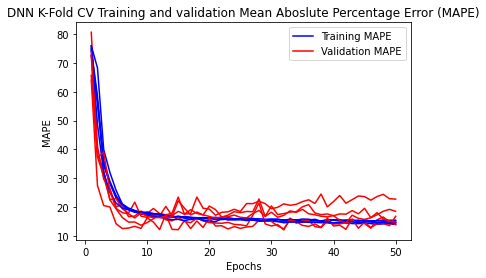

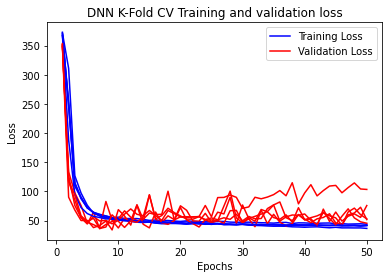

In [151]:
#@AUTHOR: DANIEL PACE
#@DATE: 4/3/2022
#@PURPOSE: Part 4: Deep Neural Network K-Fold Cross-Validation Visualization

# Plotting the training and validation Mean Absolute Percentage Error (MAPE) 
# over Epochs from the DNN Model
import matplotlib.pyplot as plt

for i in range(len(DNNCV_LossHistory)):

  loss = DNNCV_MAPEHistory[i]
  val_loss = DNNCV_ValMAPEHistory[i]
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r')

plt.title('DNN K-Fold CV Training and validation Mean Aboslute Percentage Error (MAPE)')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend(labels=['Training MAPE','Validation MAPE'])
plt.show()

# Plotting the training loss and validation loss over Epochs from the DNN Model
for i in range(len(DNNCV_LossHistory)):

  loss = DNNCV_LossHistory[i]
  val_loss = DNNCV_ValLossHistory[i]
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r')
plt.title('DNN K-Fold CV Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training Loss','Validation Loss'])
plt.show()


In [152]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 4: Deep Neural Network Model Training and Evaluation

from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# -------------- Input Parameters --------------------------

# Number of epochs to evaluate
nEpochs = 50

# Batch Sizes to evaluate
nBatchSize = 72

# Validation Split Ratio
nValidationSplit = 0.2

# Dropout layer rate
dropRate = 0.1

# Initialize the training set into np arrays
X_DNNTrain = np.array(X_train)
Y_DNNTrain = np.array(Y_train)

# Initialize the testing set into np arrays
X_DNNTest = np.array(X_test)
Y_DNNTest = np.array(Y_test)

# ----------------------------------------------------------

# Split the training data into Training and Validation data
X_DNNTraining, X_DNNVal, Y_DNNTraining, Y_DNNVal = train_test_split(X_DNNTrain, Y_DNNTrain, \
                                                    test_size=nValidationSplit, \
                                                    random_state=1)

# Initialize the model
DNNModel = Sequential()

# The Input Layer
DNNModel.add(InputLayer(input_shape=X_DNNTrain.shape[1]))

# The Hidden Layers
DNNModel.add(Dense(32, activation='relu'))
DNNModel.add(Dense(64, activation='relu'))
DNNModel.add(Dropout(dropRate))
DNNModel.add(Dense(64, activation='relu'))
DNNModel.add(Dropout(dropRate))
DNNModel.add(Dense(32, activation='relu'))

# The Output Layer
DNNModel.add(Dense(1,activation='linear'))

# Compile the DNN Model
DNNModel.compile(loss='mean_absolute_error', optimizer='adam', \
                  metrics=['mape'])

# Model Summary
DNNModel.summary()

# Train the model
DNNtraining = DNNModel.fit(X_DNNTraining,Y_DNNTraining, epochs=nEpochs, \
                    batch_size=nBatchSize, \
                    validation_data=(X_DNNVal,Y_DNNVal))

# Evaluate the Model
DNNevaluation = DNNModel.evaluate(X_DNNTest,Y_DNNTest,verbose=0)

Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_464 (Dense)           (None, 32)                128       
                                                                 
 dense_465 (Dense)           (None, 64)                2112      
                                                                 
 dropout_98 (Dropout)        (None, 64)                0         
                                                                 
 dense_466 (Dense)           (None, 64)                4160      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_467 (Dense)           (None, 32)                2080      
                                                                 
 dense_468 (Dense)           (None, 1)              

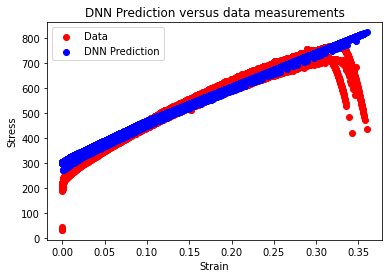

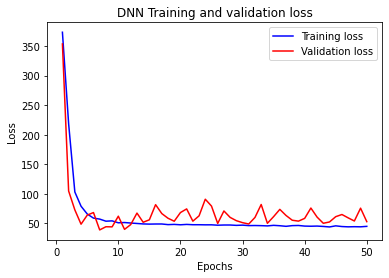

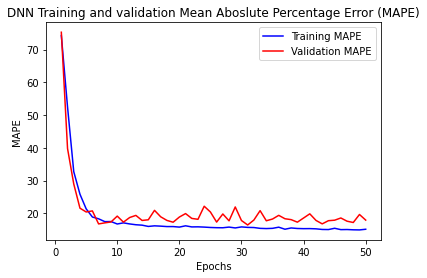

In [153]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 4: Plotting the results of the Deep Neural Network Model

import matplotlib.pyplot as plt

# Converting the X_test array to an np.array for plotting
X_pred = np.array(X_test)

# Using the DNN Model to predict answers for the Test Set(s)
DNNTestPrediction = DNNModel.predict(X_test)

# Plotting the DNN Prediction and truth-values
plt.scatter(X_pred[:,0],Y_test, color='r', label='Data')
plt.scatter(X_pred[:,0],DNNTestPrediction, color='b', label='DNN Prediction')
plt.title('DNN Prediction versus data measurements')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.legend()
plt.show()

# Plotting the training loss and validation loss over Epochs from the DNN Model
loss = DNNtraining.history['loss']
val_loss = DNNtraining.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('DNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation Mean Absolute Percentage Error (MAPE) 
# over Epochs from the DNN Model
loss = DNNtraining.history['mape']
val_loss = DNNtraining.history['val_mape']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training MAPE')
plt.plot(epochs, val_loss, 'r', label='Validation MAPE')
plt.title('DNN Training and validation Mean Aboslute Percentage Error (MAPE)')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

#5. LSTMs: 
build a LSTM network to predict flow stress for a given strain, strain-rate
and temperature. Do a study on the parameter study on the roll-out of the LSTM
required. Also, you might have to add zeros after the failure point to recognize the
failure of the material.

In [146]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 5: Long-Short Term Memory Model K-Fold Cross-Validation

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -------------- Input Parameters --------------------------

# Define the number of folds for K-Fold cross-validation
nFolds = 5

# Number of epochs to evaluate
nEpochs = 50

# Batch Sizes to evaluate
nBatchSize = 72

# Initialize the training set into np arrays
X_LSTMTrain = np.array(X_train)
Y_LSTMTrain = np.array(Y_train)

# Initialize the testing set into np arrays
X_LSTMTest = np.array(X_test)
Y_LSTMTest = np.array(Y_test)

# ----------------------------------------------------------

# Initializing the lists for DNN Loss/Accuracy K-Fold CV Study
LSTM_acc_per_fold = []
LSTM_loss_per_fold = []
LSTMCV_LossHistory = []
LSTMCV_ValLossHistory = []
LSTMCV_MAPEHistory = []
LSTMCV_ValMAPEHistory = []

# Define the K-Fold Cross Validator (CV)
kfold = KFold(n_splits=nFolds, shuffle=True, random_state=1)

# Fold Counter
nFold = 1

# Re-shapping the test data
X_LSTMTest = X_LSTMTest.reshape((X_LSTMTest.shape[0], 1, X_LSTMTest.shape[1]))

# K-Fold Cross-Validation Study
for train, val, in kfold.split(X_LSTMTrain,Y_LSTMTrain):

  #Format Data
  X_LSTMTraining = X_LSTMTrain[train]
  X_LSTMTraining = X_LSTMTraining.reshape((X_LSTMTraining.shape[0], 1, X_LSTMTraining.shape[1]))
  Y_LSTMTraining = Y_LSTMTrain[train]
  X_LSTMVal = X_LSTMTrain[val]
  X_LSTMVal = X_LSTMVal.reshape((X_LSTMVal.shape[0], 1, X_LSTMVal.shape[1]))
  Y_LSTMval = Y_LSTMTrain[val]

  # Initialize the model
  LSTMCVModel = Sequential()

  # The Input Layer
  LSTMCVModel.add(LSTM(50, \
                input_shape=(X_LSTMTraining.shape[1], X_LSTMTraining.shape[2]), \
                activation='relu'))
  LSTMCVModel.add(Dense(1, activation='linear'))

  # Compile the DNN Model
  LSTMCVModel.compile(loss='mean_absolute_error', optimizer='adam', \
                    metrics=['mape'])

  # Model Summary
  LSTMCVModel.summary()
  
  # Train the model
  LSTMCVtraining = LSTMCVModel.fit(X_LSTMTraining,Y_LSTMTraining, epochs=nEpochs, \
                      #batch_size=nBatchSize, \
                      validation_data=(X_LSTMVal,Y_LSTMval))
  
  # Evaluate the Model
  LSTMCVevaluation = LSTMCVModel.evaluate(X_LSTMTest,Y_DNNTest,verbose=0)
  print(f'Score for fold {nFold}: {LSTMCVModel.metrics_names[0]} of {LSTMCVevaluation[0]}; {LSTMCVModel.metrics_names[1]} of {LSTMCVevaluation[1]}%')
  
  LSTM_acc_per_fold.append(LSTMCVevaluation[1])
  LSTM_loss_per_fold.append(LSTMCVevaluation[0])
  LSTMCV_LossHistory.append(DNNCVtraining.history['loss'])
  LSTMCV_ValLossHistory.append(DNNCVtraining.history['val_loss'])
  LSTMCV_MAPEHistory.append(DNNCVtraining.history['mape'])
  LSTMCV_ValMAPEHistory.append(DNNCVtraining.history['val_mape'])


  nFold = nFold + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(LSTM_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {LSTM_loss_per_fold[i]} - MAPE: {LSTM_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(LSTM_acc_per_fold)} (+- {np.std(LSTM_acc_per_fold)})')
print(f'> Loss: {np.mean(LSTM_loss_per_fold)}')
print('------------------------------------------------------------------------')


Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 50)                10800     
                                                                 
 dense_433 (Dense)           (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1133/1133 [==============================] - 4s 3ms/step - loss: 380.1055 - mape: 74.2023 - val_loss: 356.8441 - val_mape: 80.0970
Epoch 2/50
1133/1133 [==============================] - 3s 2ms/step - loss: 352.7745 - mape: 71.4824 - val_loss: 351.9610 - val_mape: 80.5833
Epoch 3/50
1133/1133 [==============================] - 3s 2ms/step - loss: 346.8043 - mape: 70.5095 - val_loss: 344.5315 - val_mape: 77.4083
Epoch 4/50
1133/11

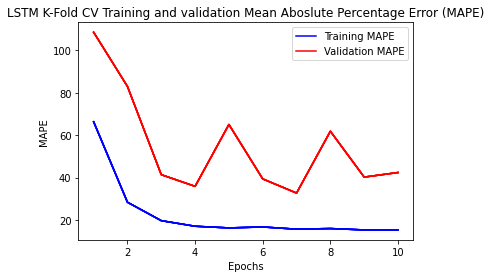

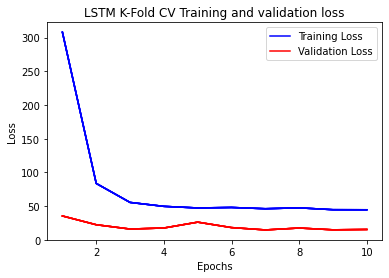

In [147]:
#@AUTHOR: DANIEL PACE
#@DATE: 4/3/2022
#@PURPOSE: Part 5: Long-Short Term Memory K-Fold Cross-Validation Visualization

# Plotting the training and validation Mean Absolute Percentage Error (MAPE) 
# over Epochs from the LSTM Model
import matplotlib.pyplot as plt

for i in range(len(LSTMCV_LossHistory)):

  loss = LSTMCV_MAPEHistory[i]
  val_loss = LSTMCV_ValLossHistory[i]
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r')

plt.title('LSTM K-Fold CV Training and validation Mean Aboslute Percentage Error (MAPE)')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend(labels=['Training MAPE','Validation MAPE'])
plt.show()

# Plotting the training loss and validation loss over Epochs from the LSTM Model
for i in range(len(LSTMCV_LossHistory)):

  loss = LSTMCV_LossHistory[i]
  val_loss = LSTMCV_ValMAPEHistory[i]
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r')
plt.title('LSTM K-Fold CV Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training Loss','Validation Loss'])
plt.show()

In [148]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 5: Long-Short Term Model Training and Evaluation

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# -------------- Input Parameters --------------------------

# Define the number of folds for K-Fold cross-validation
nFolds = 5

# Number of epochs to evaluate
nEpochs = 50

# Batch Sizes to evaluate
nBatchSize = 72

# Drop out rate
dropRate = 0.1

# Initialize the training set into np arrays
X_LSTMTrain = np.array(X_train)
Y_LSTMTrain = np.array(Y_train)

# Initialize the testing set into np arrays
X_LSTMTest = np.array(X_test)
Y_LSTMTest = np.array(Y_test)

# ----------------------------------------------------------

# Split the training data into Training and Validation data
X_LSTMTraining, X_LSTMVal, Y_LSTMTraining, Y_LSTMVal = train_test_split(X_LSTMTrain, Y_LSTMTrain, \
                                                    test_size=nValidationSplit, \
                                                    random_state=42)

#Format Data
X_LSTMTraining = X_LSTMTraining.reshape((X_LSTMTraining.shape[0], 1, X_LSTMTraining.shape[1]))
X_LSTMVal = X_LSTMVal.reshape((X_LSTMVal.shape[0], 1, X_LSTMVal.shape[1]))
X_LSTMTest = X_LSTMTest.reshape((X_LSTMTest.shape[0], 1, X_LSTMTest.shape[1]))

# Initialize the model
LSTMModel = Sequential()

# The Input Layer
LSTMModel.add(LSTM(50, \
               input_shape=(X_LSTMTraining.shape[1], X_LSTMTraining.shape[2]), \
               activation='relu'))
LSTMModel.add(Dense(1, activation='linear'))

# Compile the DNN Model
LSTMModel.compile(loss='mean_absolute_error', optimizer='adam', \
                  metrics=['mape'])

# Model Summary
LSTMModel.summary()

# Train the model
LSTMtraining = LSTMModel.fit(X_LSTMTraining,Y_LSTMTraining, epochs=nEpochs, \
                    #batch_size=nBatchSize, \
                    validation_data=(X_LSTMVal,Y_LSTMVal), shuffle=False)

# Evaluate the Model
LSTMevaluation = LSTMModel.evaluate(X_LSTMTest,Y_LSTMTest,verbose=0)

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 50)                10800     
                                                                 
 dense_438 (Dense)           (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1133/1133 [==============================] - 4s 2ms/step - loss: 359.3888 - mape: 70.5273 - val_loss: 266.0238 - val_mape: 62.1970
Epoch 2/50
1133/1133 [==============================] - 2s 2ms/step - loss: 209.7912 - mape: 48.1515 - val_loss: 175.7271 - val_mape: 48.3277
Epoch 3/50
1133/1133 [==============================] - 2s 2ms/step - loss: 162.8890 - mape: 43.0532 - val_loss: 156.3218 - val_mape: 46.8680
Epoch 4/50
1133/11

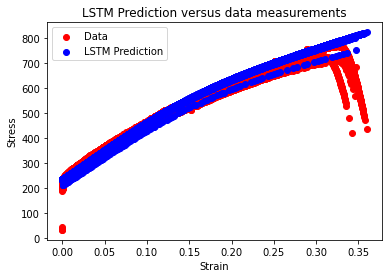

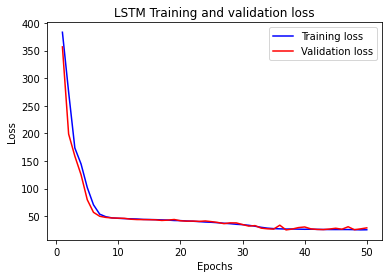

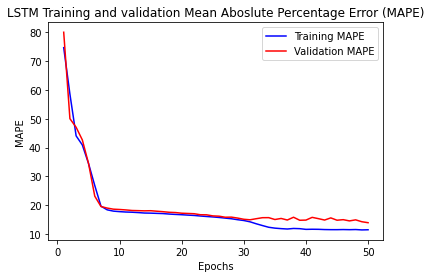

In [134]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 5: Plotting the results of the Long-Short Term Memory Model
import matplotlib.pyplot as plt

# Converting the X_test array to an np.array for plotting
X_pred = np.array(X_test)

# Using the DNN Model to predict answers for the Test Set(s)
LSTMTestPrediction = LSTMModel.predict(X_LSTMTest)

# Plotting the DNN Prediction and truth-values
plt.scatter(X_pred[:,0],Y_test, color='r', label='Data')
plt.scatter(X_pred[:,0],LSTMTestPrediction, color='b', label='LSTM Prediction')
plt.title('LSTM Prediction versus data measurements')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.legend()
plt.show()

# Plotting the training loss and validation loss over Epochs from the DNN Model
loss = LSTMtraining.history['loss']
val_loss = LSTMtraining.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation Mean Absolute Percentage Error (MAPE) 
# over Epochs from the DNN Model
loss = LSTMtraining.history['mape']
val_loss = LSTMtraining.history['val_mape']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training MAPE')
plt.plot(epochs, val_loss, 'r', label='Validation MAPE')
plt.title('LSTM Training and validation Mean Aboslute Percentage Error (MAPE)')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

#6. Deployment: 
The true stress and true strain results are obtained for a sheet metal.
Tensile testing is performed on a small rectangular strip, 6cm in length and the jaws
holding one end of the specimen and the other side is pulled by a displacement of
x. For all the experiments in the data, displacement is such a way that the strain
rate is constant through out the process. However, in forming, strain rate varies
non-linearly. Example: your displacement could be represented as x= t3−2t2+ t.
Then, predict the stress-strain curve for this profile of displacements. (Hint: you
need to use the Hooke’s law and related components to convert the xto strains and
strain rates and then eventually computing the stress strain curve for same).

In [161]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 6: Initialize Deployment Data

# The rectangular cross-section length
l = 6
# The rectangular cross sectional area
a = l * l
# Non-linear Displacement funciton assumption
t = np.linspace(0,2)
e = t*t*t - 2*t*t + t
e_dot = 3*t*t - 4*t + 1
# Calculate the strain 
strain = e / l
# Calculate the strain-rate
strainRate = e_dot / l
# Temperature Assumption
temp = 400
# Initialize X-input vector for deployment
X_deployment = []

# Loop through data and organize data-structure in a list of lists
for i in range(len(e)):
  input = [strain[i], strainRate[i], temp]
  X_deployment.append(input)

# Convert the list of lists to an np.array of lists
X_deployment = np.array(X_deployment)

#7. Presenting results: 
Compare the results you obtain for training, validation and
testing data on the naive learning model and the LSTM. Visualize the stress-strain
curves of the predicted (both) and the actual. Also, visualize the stress-strain curve
for the deployment for both the learning cases.

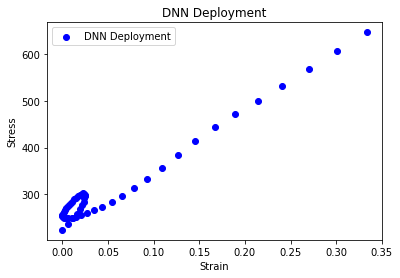

In [162]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 7: Deployment of DNN Results
import matplotlib.pyplot as plt

# Utilizing DNN Model from Part 4 to predict Stresses
DNN_deployment = DNNModel.predict(X_deployment)

if len(DNN_deployment) != 0:
  # Plotting the results of the DNN Deployment prediction
  plt.scatter(X_deployment[:,0],DNN_deployment,color='b',label='DNN Deployment')
  plt.legend()
  plt.title('DNN Deployment')
  plt.xlabel('Strain')
  plt.ylabel('Stress')
  plt.show()

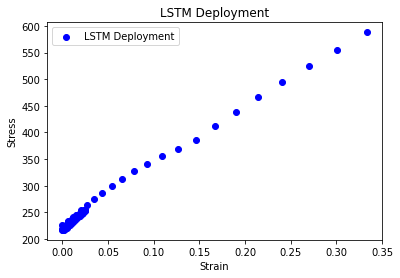

In [158]:
#@AUTHOR: DANIEL PACE
#@DATE: 3/30/2022
#@PURPOSE: Part 7: Deployment of LSTM Results
import matplotlib.pyplot as plt

# Utilizing LSTM Model from Part 4 to predict Stresses
X_deploymentLSTM = X_deployment.reshape((X_deployment.shape[0], 1, X_deployment.shape[1]))

LSTM_deployment = LSTMModel.predict(X_deploymentLSTM)

if len(LSTM_deployment) != 0:
  # Plotting the results of the LSTM Deployment prediction
  plt.scatter(X_deployment[:,0],LSTM_deployment,color='b',label='LSTM Deployment')
  plt.legend()
  plt.title('LSTM Deployment')
  plt.xlabel('Strain')
  plt.ylabel('Stress')
  plt.show()